Imports

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If in Colab, we need to pull utilities from github
if IN_COLAB:
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/load_model.py
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/utils.py
  !wget https://raw.githubusercontent.com/soberhofer/Importance_based_Adversarial_Examples/main/ImagenetteDataset.py

In [35]:
%pip install -q grad-cam

from utils import imshow, imagenette_outputs, multiple_c_o_m, shift, sort_pairs, set_seeds
from ImagenetteDataset import ImagenetteDataset
from load_model import load_model
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torchvision, torch, torchvision.transforms as T
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
from scipy.ndimage import center_of_mass

# Captum
from captum.attr import IntegratedGradients, NoiseTunnel, DeepLift, Occlusion
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

Note: you may need to restart the kernel to use updated packages.


Configure Size of Imagenette Pictures and PyTorch Device

In [36]:
imagenette_labels= {
  0: "fish",
  1: "dog",
  2: "cassette player",
  3: "chain saw",
  4: "church",
  5: "French horn",
  6: "garbage truck",
  7: "gas pump",
  8: "golf ball",
  9: "parachute"
}

# Set seeds for reproducibility
set_seeds(42)

#160 uses ~8GB RAM, 320 uses ~24GB RAM, Fullsize not tested
size = 320
bs = 16
# ScoreCAM seems not to work with mps
# AblationCAM is funky
#cams = [AblationCAM]
cams = [XGradCAM]
#cams = [EigenCAM, EigenGradCAM, XGradCAM, GradCAM, HiResCAM, GradCAMPlusPlus]

if torch.cuda.is_available():
  device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    %env PYTORCH_ENABLE_MPS_FALLBACK=1
else:
  device = "cpu"

print(device)


env: PYTORCH_ENABLE_MPS_FALLBACK=1
mps


Download and unpack images

In [37]:
if size in [160, 320]:
  #Download resized images
  if not os.path.isfile(f'imagenette2-{size}.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-{size}.tgz
    !tar -xf imagenette2-{size}.tgz
elif os.path.isdir(f"imagenette2-{size}"):
    print("Data is present, continuing")
else:
  #Download original images
  print("Downloading originals and resizing")
  if not os.path.isfile(f'imagenette2.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    !tar -xf imagenette2.tgz
    # Downscale to chosen size
    folder_dir = f"imagenette2-{size}"
    os.rename("imagenette2",folder_dir)
    for dataset in ["train","val"]:
      for classes in os.listdir(f"{folder_dir}/{dataset}"):
        for image in os.listdir(f"{folder_dir}/{dataset}/{classes}"):
          image_path = f"{folder_dir}/{dataset}/{classes}/{image}"
          img = Image.open(image_path)
          img.thumbnail((size,size))
          os.remove(image_path)
          img.save(image_path)



Load Model and target Layers for GradCam

In [38]:
model, target_layers = load_model('mobilenet', norm_layer=True)
model.to(device);


Build our DataLoaders

In [39]:


trainset = ImagenetteDataset(size, should_normalize=False)
valset = ImagenetteDataset(size, should_normalize=False, validation=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = bs, shuffle = True)
valloader = torch.utils.data.DataLoader(valset, batch_size = bs, shuffle = True)




In [7]:
print(len(trainset))
print(len(valset))

9469
3925


Get first Batch for Testing

In [33]:
data_batch, labels_batch = next(iter(trainloader))
print(data_batch.size())
print(labels_batch.size())
out = torchvision.utils.make_grid(data_batch)

torch.Size([64, 3, 320, 320])
torch.Size([64])


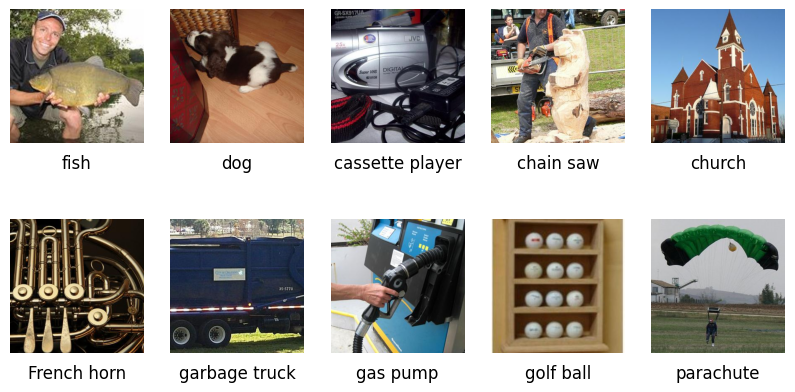

In [34]:
imgs = []
labels=[]
for i in range(10):
  for img, label in zip(data_batch, labels_batch):
    if label.item() == i:
      labels.append(imagenette_labels[label.item()])
      imgs.append(img.permute(1,2,0).numpy())
      #imshow(img, denorm=False)
      break

# Plot images in a 2x5 grid with labels without axis
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for img, lbl, ax in zip(imgs, labels, axs):    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(lbl,y=-0.25)



Predict First Batch with our model

In [16]:
model.to(device)
class_names = trainset.classes
print(class_names)
outputs = model(data_batch.to(device))
print(outputs.shape)
preds = imagenette_outputs(outputs)
print(labels_batch)
#print(preds)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
torch.Size([16, 1000])
tensor([7, 9, 5, 8, 2, 3, 8, 6, 6, 7, 2, 9, 8, 5, 1, 3])


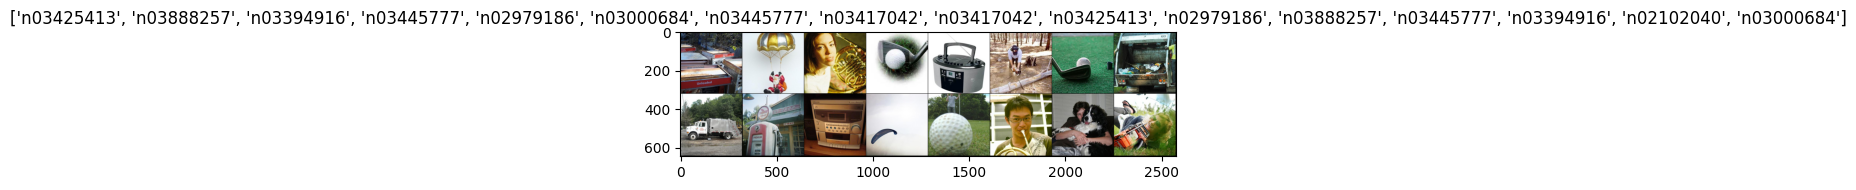

In [17]:

imshow(out, denorm=False, title=[class_names[x] for x in preds])

Run Inference on whole trainset

In [ ]:
all_predictions = []
num_correct = 0
with torch.no_grad():
  loop = tqdm(trainloader)
  for idx, (data, labels) in enumerate(loop):
    outputs = model(data.to(device))
    preds = imagenette_outputs(outputs)
    all_predictions.extend(preds)
    corrects = torch.sum(preds == labels.to(device))
    num_correct += corrects
    loop.set_description(f"Processing batch {idx+1}")
    loop.set_postfix(current_accuracy = num_correct.float().item()/(len(labels)*(idx+1)))
    #print(f"Done with batch of size {(len(labels))}")
pred = torch.stack(all_predictions)



In [ ]:
print("Accuracy: {:.4f}".format(num_correct.double()/len(trainset)))

In [ ]:
print(pred.size())
print(pred[0:100])

Generate Adversarial Examples

In [40]:

cutoff = 0.3


cams = [IntegratedGradients]
#Iterate over all cams
for ourcam in cams:
  #Create folder for results
  folder = f"./adv_examples_{ourcam.__name__}_{size}_{cutoff}/"
  if not os.path.exists(folder):
    os.mkdir(folder)
  
  #Create CAM
  cam = ourcam(model)
  #cam = ourcam(model=model, target_layers=target_layers)
  


  # To avoid bias, we only use images which have been used as test set during training
  loop = tqdm(valloader)
  examples = []
  found = 0
  thirdlabel = 0
  same = 0
  invalid = 0
  bad_ex = 0
    
  for batch, (data, labels) in enumerate(loop):

    #make sure we have even number of samples, if not, remove the last one. Use even block size to avoid this
    if len(labels) % 2 != 0:
      data = data[:-1,:,:,:]
      labels = labels[:-1]

    # Sort the batch so that the base and attack image do not have the same label
    # we try it for bs^2 times and then stop, some batches are not sortable in this way
    # we should get almost all of them sorted nicely though
    data, labels = data.to(device), labels.to(device)
    
    #loop.set_description(f"Sorting batch...")
    sort_pairs(data, labels, bs)
    
    # get the CAMs for the batch
    #loop.set_description(f"Calculating CAMs...")
    grayscale_cam = cam.attribute(data, target=labels)#, n_steps=50)
    #print(f"before transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
    tograyscale = torchvision.transforms.Grayscale()
    grayscale_cam = tograyscale(grayscale_cam)
    #grayscale_cam = grayscale_cam.squeeze(0).squeeze().detach().cpu().numpy()
    #print(f"after transform: {grayscale_cam.shape=}, {type(grayscale_cam)=}")
    #grayscale_cam = cam(input_tensor=data, targets=None)
    grayscale_cam = F.interpolate(grayscale_cam, size=(7,7), mode='bilinear', align_corners=False)
    grayscale_cam = F.interpolate(grayscale_cam, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()
    cams_base, cams_attack = np.array_split(grayscale_cam, 2, axis=0)
    imgs_base, imgs_attack = np.array_split(data.cpu().numpy(), 2, axis=0)
    labels_base, labels_attack = np.array_split(labels.cpu().numpy(), 2, axis=0)
    #iterate over each batch
    for base_img, attack_img, base_cam, attack_cam, base_label, attack_label in zip(imgs_base, imgs_attack, cams_base, cams_attack, labels_base, labels_attack):
      # ignore pairs with same label (should not happen too often now)
      if (attack_label == base_label):
        same += 1
        continue
      #start with a 99% mask
      current_threshold = cutoff
      
      # Look for the adversarial Example
      while True:
        thresholds = [x[4] for x in examples]
        loop.set_description(f"Found: {found}, 3rdlabel: {thirdlabel} same label: {same}, invalid: {invalid}, bad_ex: {bad_ex}, median threshold: {np.median(thresholds):.2f} using {ourcam.__name__}")
        base_threshold = np.quantile(base_cam.flatten(), current_threshold)
        attack_threshold = np.quantile(attack_cam.flatten(), current_threshold)
        base_mask = np.where(base_cam>base_threshold, np.ones_like(base_cam), np.zeros_like(base_cam))
        attack_mask = np.where(attack_cam>attack_threshold, np.ones_like(attack_cam), np.zeros_like(attack_cam))
        c_o_m_base = np.array(center_of_mass(base_mask))
        c_o_m_attack = np.array(center_of_mass(attack_mask))
        offset = c_o_m_base - c_o_m_attack

        # Remember the last image we produced, in case this is the adversarial example
        if 'invariance_adv' in locals():
          last_img = invariance_adv.copy()

        #Produce the example
        #print(attack_img.shape, offset.shape)
        invariance_adv = np.where(base_mask==True, shift(attack_img, offset), base_img)

        #Check output of Model
        output = imagenette_outputs(model(torch.from_numpy(invariance_adv).unsqueeze(0).to(device)))
        
        if output.item() == base_label:
          # threshold <= 0.01 means we have a mask of 99% -> we can't find an adversarial example
          if current_threshold <= 0.01:
            invalid +=1
            break
          #Model still predicts base label -> make mask bigger
          current_threshold -= 0.01
        else:
          # threshold >= 0.99 means we have a mask of 1% and the model already flips label. We can't find an adversarial example
          if current_threshold >= 0.99:
            invalid +=1
            break
          #model flips early, we look for a better example
          if current_threshold >= cutoff:
            bad_ex += 1
            break
          #We found the example. Write it to disk
          img = Image.fromarray((last_img*255).astype(np.uint8).transpose(1,2,0))
          #Format of image name: base_label_attack_label_intermediate_label_threshold.jpg
          
          Image.fromarray((attack_cam*255).astype(np.uint8)).save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}_attackcam.jpg")
          Image.fromarray((base_cam*255).astype(np.uint8)).save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}_basecam.jpg")
          img.save(f"{folder}/{base_label}_{attack_label}_{output.item()}_{current_threshold:.2f}.jpg")
          examples.append((last_img, base_label, attack_label, output.item(), current_threshold))
          if output.item() != attack_label:
            thirdlabel += 1
          else:
            found += 1
          break
  with open(f"{folder}/results.txt", "w") as f:
    thresholds = [x[4] for x in examples]
    f.write(f"Found: {found}, 3rdlabel: {thirdlabel} same label: {same}, invalid: {invalid}, bad: {bad_ex}, median threshold: {np.median(thresholds):.2f} using {ourcam.__name__}, cutoff {cutoff} and {size}x{size} images")

  0%|          | 0/62 [00:06<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 12.29 GB, other allocations: 4.67 GB, max allowed: 20.40 GB). Tried to allocate 4.88 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
from torchvision import transforms
convert_tensor = transforms.PILToTensor()
# Check if outputs are correct
for image in examples:

  output = imagenette_outputs(model(torch.from_numpy(image[0]).unsqueeze(0).to(device)))
  # Make sure model predicts base_label for adv_example
  if output.item() != image[1]:
    print(f"Wrong output for {image[1]}_{image[2]}: {output[3]} with {image[4]:.2f}")

  # Make sure image has correct shape
  if image[0].shape != (3, size, size):
    print(f"Wrong shape for {image[1]}_{image[2]}: {image[0].shape}")
   


#### Results

##### valset 320px 
Found: 135, 3rdlabel: 26 same label: 18, invalid: 109, bad_ex: 1673, cutoff: 0.3,  Median 0.25, best: 0.13. Gradcam Time 38:53

Found: 203, 3rdlabel: 82 same label: 18, invalid: 443, bad_ex: 1215, using EigenCAM: 10:25 0.5\
Found: 148, 3rdlabel: 55 same label: 18, invalid: 328, bad_ex: 1412, using EigenGradCAM: 08:42 0.5\
Found: 634, 3rdlabel: 153 same label: 18, invalid: 89, bad_ex: 1067, using XGradCAM: 05:53 0.5\
Found: 257, 3rdlabel: 114 same label: 18, invalid: 22, bad_ex: 1550, using GradCAM: 03:01 0.5\
Found: 204, 3rdlabel: 117 same label: 18, invalid: 6, bad_ex: 1616, using HiResCAM: 02:34 0.5\
Found: 406, 3rdlabel: 117 same label: 18, invalid: 62, bad_ex: 1358, using GradCAMPlusPlus: 04:16 0.5

Found: 41, 3rdlabel: 8 same label: 18, invalid: 500, bad_ex: 1394, median threshold: 0.25 using EigenCAM: 07:29\
Found: 39, 3rdlabel: 10 same label: 18, invalid: 376, bad_ex: 1518, median threshold: 0.25 using EigenGradCAM: 06:35\
Found: 166, 3rdlabel: 32 same label: 18, invalid: 108, bad_ex: 1637, median threshold: 0.25 using XGradCAM: 02:56\
Found: 61, 3rdlabel: 15 same label: 18, invalid: 31, bad_ex: 1836, median threshold: 0.25 using GradCAM: 02:03\
Found: 37, 3rdlabel: 26 same label: 18, invalid: 6, bad_ex: 1874, median threshold: 0.27 using HiResCAM: 01:48\
Found: 89, 3rdlabel: 25 same label: 18, invalid: 79, bad_ex: 1750, median threshold: 0.26 using GradCAMPlusPlus: 02:33\

Found: 104, 3rdlabel: 39 same label: 18, invalid: 0, bad_ex: 1800, median threshold: 0.26 using XGradCAM with aug_smooth 03:03\
Found: 93, 3rdlabel: 27 same label: 18, invalid: 176, bad_ex: 1647, median threshold: 0.26 using XGradCAM with eigen_smooth 04:51\

Found: 276, 3rdlabel: 62 same label: 16, invalid: 0, bad_ex: 1607, median threshold: 0.24 using IntegratedGradients: 09:09

0.03, dog, parachute, parachute
Median: 0.24


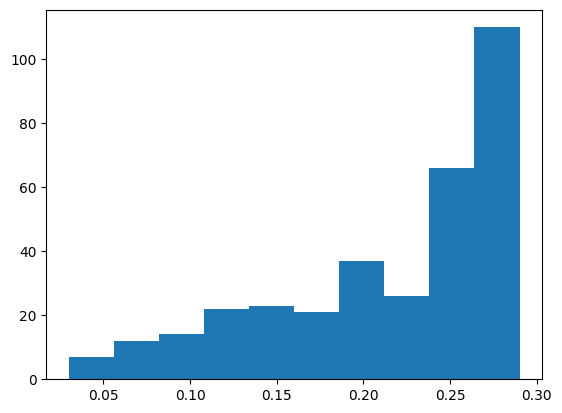

In [ ]:
examples.sort(key=lambda x: x[4], reverse=False)
#examples.sort(key=lambda x: (x[4]-0.5)**2, reverse=True)
idx = 0
#for idx in range(30):
#  print(f"{examples[idx][4]:.2f}")
print(f"{examples[idx][4]:.2f}, {imagenette_labels[examples[idx][1]]}, {imagenette_labels[examples[idx][2]]}, {imagenette_labels[examples[idx][3]]}")
#plt.imshow(examples[idx][0].transpose(1,2,0))
thresholds = [x[4] for x in examples]
#print median
print(f"Median: {np.median(thresholds):.2f}")
plt.hist(thresholds);


In [10]:
import AdvExample
myexamples = []
for file in folder:
  if file.endswith(".jpg"):
    myexamples.append(AdvExample(file))

myexamples.sort(key=lambda x: x.threshold, reverse=False)

Export Pictures to disk

In [ ]:
# for idx, img in enumerate(examples):
#   img = Image.fromarray((img*255).astype(np.uint8).transpose(1,2,0))
#   img.save(f"/content/drive/MyDrive/adv_examples_320/{idx}.jpg")

Plot some of the Pictures

In [ ]:

# f, xarr = plt.subplots(2,2, figsize=(15,15))
# xarr.flatten()
# for idx, ax in enumerate(xarr.flatten()):
#   ax.imshow(examples[idx][0].transpose(1,2,0))

In [ ]:
# idx = 4
# com_b = c_o_m_base[idx]
# com_a = c_o_m_attack[idx]
# offset = offsets[idx]
# base_image = imgs_base[idx]
# attack_image = imgs_attack[idx]
# print (base_image.shape)
# print (attack_image.shape)
# fig, ax = plt.subplots(1, 2, figsize=(20, 20))
# ax = ax.flatten()
# ax[0].imshow(base_image.transpose(1,2,0))
# ax[0].scatter(com_b[0], com_b[1], s=size, c='C0', marker='+')
# ax[1].imshow(attack_image.transpose(1,2,0))
# ax[1].scatter(com_a[0], com_a[1], s=size, c='C1', marker='+')
# ax[1].scatter(com_b[0], com_b[1], s=size, c='C0', marker='+')


In [ ]:
# print(attack_image.shape)
# shifted = shift(attack_image, offset)
# #print(offset[::-1])
# print (shifted.shape)
# plt.imshow(shifted.transpose(1,2,0))

# # print(com_b, com_a, offset)
# # attack_image_cropped = attack_image[:,39:,11:]
# # #plt.imshow(attack_image_cropped.transpose(1,2,0))
# # print(attack_image_cropped.shape)
# # empty = np.zeros_like(attack_image)
# # empty[:,0:121,0:149] = attack_image_cropped
# # print(empty.shape)



In [ ]:
# invariance_adv = np.where(masks_base[0]==True, shifted, base_image)
# plt.imshow(invariance_adv.transpose(1,2,0))

In [ ]:
# from scipy.ndimage import shift
# print(offsets[11])
# print(masked_base[11].shape)
# print(offsets[0,0])
# print (offsets[:,0])
# one_image = imgs_attack[:,:,offsets[:,0]:,offsets[:,1]:]

# #shifted = shift(masked_base[11], offsets[11], cval=0)
# plt.imshow(attack_patches[4].transpose(1,2,0))
# #plt.imshow(masked_base[11].transpose(1,2,0))

In [ ]:
# print(normalized.shape)
# fig, ax = plt.subplots(2, 4, figsize=(20, 20))
# ax = ax.flatten()
# for i in range(8):
#   idx = random.randint(0, len(masked_images)-1)
#   ax[i].imshow(normalized[idx].transpose(0,1))


In [ ]:
# c_o_m = multiple_c_o_m(masked_images)

# print(c_o_m.shape)
# #c_o_m

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=(20, 20))
# ax = ax.flatten()
# for i in range(8):
#   idx = random.randint(0, len(masked_images)-1)
#   ax[i].imshow(masked_images[idx].transpose(1,2,0))
#   ax[i].scatter(c_o_m[idx][0], c_o_m[idx][1], s=size, c='C0', marker='+')
#   print(idx, c_o_m[idx])


# plt.show()

In [ ]:
# #not needed
# threshold = np.quantile(gradcam_hm.flatten(), .85)
# b_mask = np.where(gradcam_hm>threshold, np.ones_like(gradcam_hm), np.zeros_like(gradcam_hm))
# print (b_mask.shape)
# img_batch = next(iter(trainloader))[0]
# idx = 4
# plt.imshow((b_mask[idx]*img_batch[idx].detach().cpu().numpy()).transpose(1,2,0))

Explainability with Pytorch Captum

In [148]:
#%pip install -q git+https://github.com/pytorch/captum.git

from captum.attr import IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

Integrated Gradients

In [149]:
device = torch.device("mps")
#ig = IntegratedGradients(model)
ig = IntegratedGradients(model)
data, labels = next(iter(trainloader))


In [150]:
idx = 2
input = data[idx].unsqueeze(0).to(device)
label = labels[idx].to(device)
#print(input.shape)
#print (data[0].size())
#attributions, delta = ig.attribute(input, target=label, n_steps=200, return_convergence_delta=True)
attributions = ig.attribute(input, target=label)

#cam = GradCAM(model=model, target_layers=target_layers, device=torch.device("mps"))
#cam = cam(input_tensor=input, targets=None, eigen_smooth=True)
tograyscale = torchvision.transforms.Grayscale()
attributions = tograyscale(attributions)
print(type(attributions))
#print(type(cam))
print(attributions.shape)
#print(cam.shape)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)



<class 'torch.Tensor'>
torch.Size([1, 1, 320, 320])


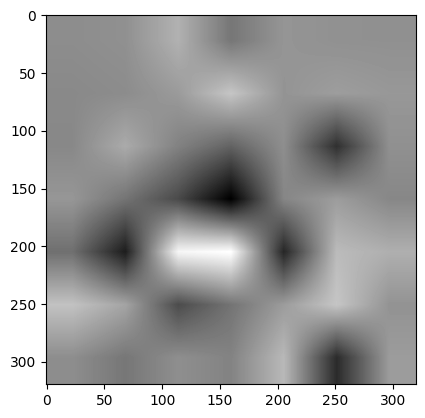

In [151]:
cam_size = 7
attributions = F.interpolate(attributions, size=(cam_size,cam_size), mode='bilinear', align_corners=False)
attributions = F.interpolate(attributions, size=(size,size), mode='bilinear', align_corners=False).squeeze().detach().cpu().numpy()
plt.imshow(attributions, cmap='gray')

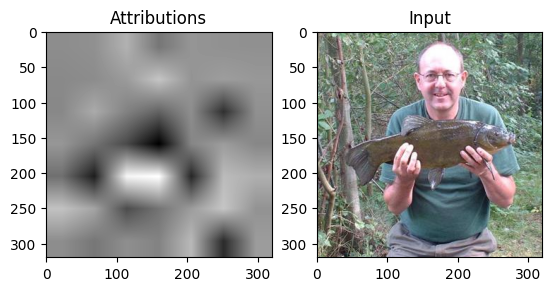

In [152]:
#res = cv2.resize(np.transpose(attributions, (1,2,0)), dsize=(7, 7), interpolation=cv2.INTER_CUBIC)
import matplotlib.pyplot as plt

# Plot attributions
plt.subplot(1, 2, 1)
plt.imshow(attributions, cmap='gray')
plt.title('Attributions')

# Plot input
plt.subplot(1, 2, 2)
plt.imshow(input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
plt.title('Input')

plt.show()



In [45]:
import scipy.ndimage as ndimage
ig_smoothed = ndimage.gaussian_filter(attributions, 1, mode='nearest')
plt.imshow(np.transpose(ig_smoothed, (1,2,0)), cmap='gray')

ValueError: axes don't match array

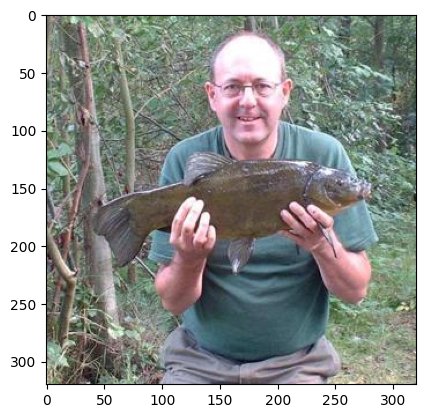

In [153]:
imshow(data[idx], denorm=False)

Noise Tunnel for Smooting

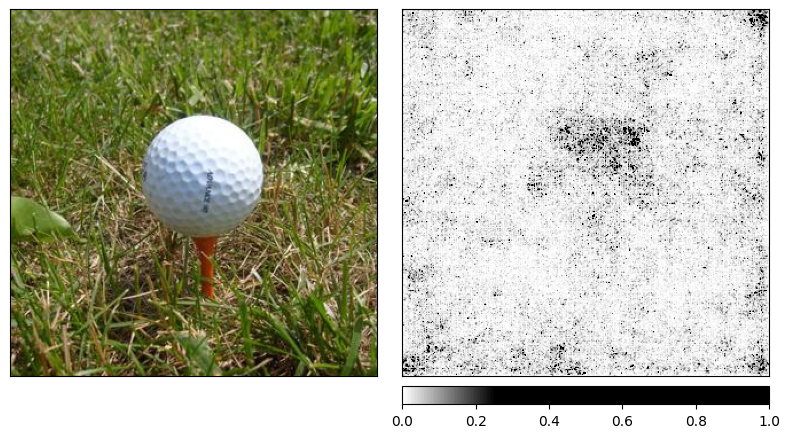

In [33]:
# nt_samples <= 7 for 15GB VRAM 
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=4, nt_type='smoothgrad_sq', target=label)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [18]:
#plt.imshow(show_cam_on_image(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                      np.transpose(data[idx].squeeze().cpu().detach().numpy(), (1,2,0)), use_rgb=True))

NameError: name 'show_cam_on_image' is not defined